# ECSE415 - Assignment 2 

In [129]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# 3 - Object Detection

## Training

### 1 - Resize the training images to 128 × 128

In [130]:
pathname = ['car1.jpg', 'car2.jpg', 'car3.jpg', 'car4.jpg',
            'car5.jpg', 'car6.jpg', 'car7.jpg', 'car8.jpg','car9.jpg',
            'car10.jpg','car11.jpg','car12.jpg','car13.jpg', 'car14.jpg']
img_cars = [None] * 14

num = len(img_cars)
for i in range(num):
    img_cars[i] = cv2.cvtColor(cv2.imread(pathname[i]), cv2.COLOR_BGR2RGB)
    img_cars[i] = cv2.resize(img_cars[i], (128, 128))
#     plt.imshow(img_cars[i])
#     plt.show()
    
    
    


### 2 - Compute HoG features

In [131]:
def func_HOG(img_list):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    #list of hog features
    hog_feats = [None] * len(img_list)

    #all images have the same shape, take parameters of first image
    img = img_list[0]
    # create HoG Object
    # winSize is the size of the image cropped to multiple of the cell size
    # all arguments should be given in terms of number of pixels
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])



    num = len(img_list)
    for i in range(num):
        # Compute HoG features
        hog_feats[i] = hog.compute(img_list[i]) \
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[1], block_size[0], nbins) \
                       .transpose((1, 0, 3, 2, 4))  # index blocks by rows first

    return (hog_feats)

hog_feats_left = func_HOG(img_cars)

### 3 - Calculate and store the mean feature map across training images

In [132]:
#add every element in the list and divide by 14
hog_sum = 0
for i in range(num):
    hog_sum += hog_feats_left[i]
    
hog_mean_left = hog_sum / num


    


### 4 - Repeat above steps for training images flipped around vertical axis

In [133]:
img_cars_right = [None] * 14
for i in range(num):
    img_cars_right[i] = cv2.flip(img_cars[i], 1)
#     plt.imshow(img_cars_flip[i])
#     plt.show()
    

hog_feats_right = func_HOG(img_cars_right)

hog_sum = 0
for i in range(num):
    hog_sum += hog_feats_right[i]
    
hog_mean_right = hog_sum / num



### 5 - Display 9 orientation channels of the mean feature maps for the first block

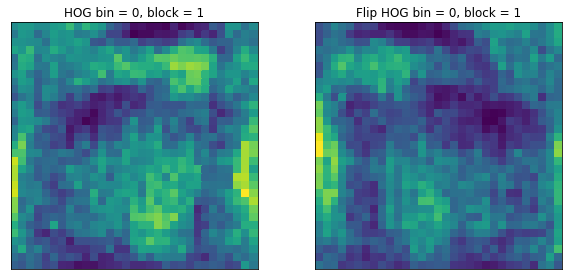

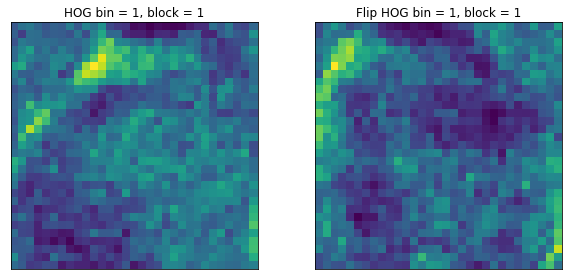

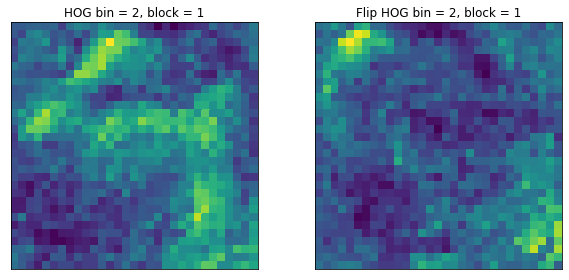

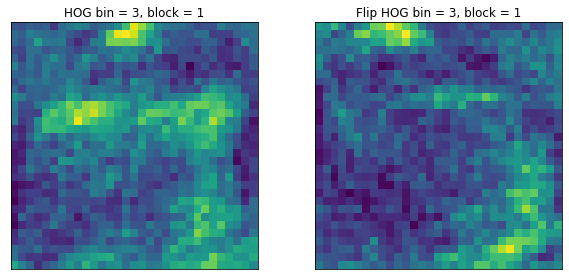

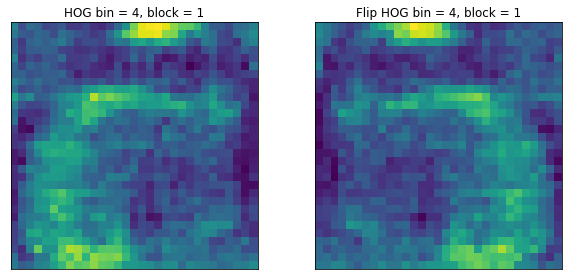

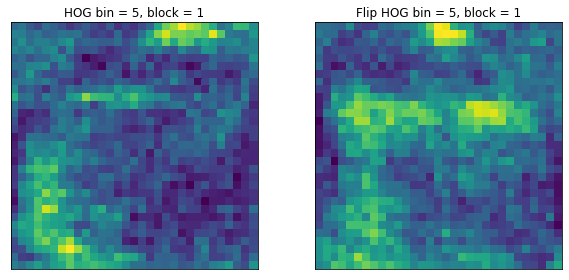

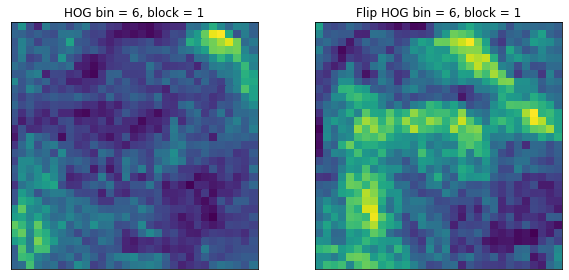

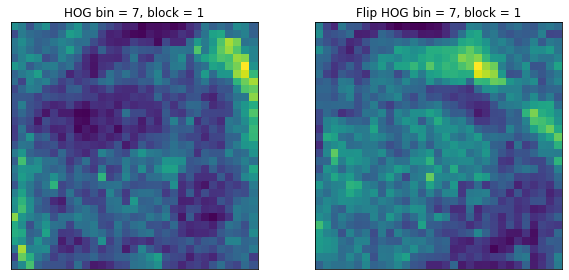

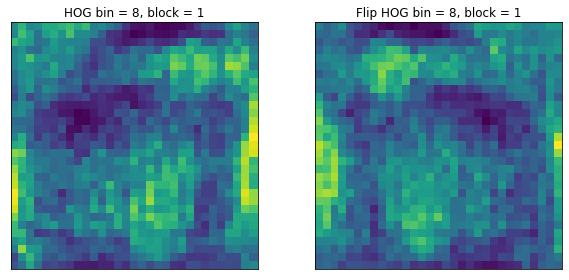

In [134]:
## display straight
for i in range(9):
    #straight
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.pcolor(hog_mean_left[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = " + str(i) + ", block = 1"), plt.xticks([]), plt.yticks([])
    
    #flipped
    plt.subplot(2,2,2)
    plt.pcolor(hog_mean_right[:, :, 0,0,i])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Flip HOG bin = " + str(i) + ", block = 1"), plt.xticks([]), plt.yticks([])
    plt.show()

# # display flip
# for i in range(9):
#     plt.figure(figsize=(10,10))
#     plt.pcolor(hog_mean_flip[:, :, 0,0,i])
#     plt.gca().invert_yaxis()
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.title("Flip HOG bin = " + str(i) + ", block = 1"), plt.xticks([]), plt.yticks([])
#     plt.show()


## Testing

### 1 - Extract overlapping windows from the test image

In [167]:
testImage = cv2.cvtColor(cv2.imread('test.jpg'), cv2.COLOR_BGR2RGB)

stepSize = 100
heightW = 170
widthW = 128
windowSize =[heightW,widthW]

def sliding_window_xy(image, stepSize, windowSize):
    windows_data = []
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            windows_data.append((np.array(image[y:y + widthW, x:x + heightW]), x , y))    
    return windows_data    
    

windows = sliding_window_xy(testImage, stepSize, windowSize )


### 2 - Resize windows to 128 × 128 and Compute HoG features similar to what was done during training

In [168]:
# get a list of resized images only so we can use it in the hog function defined above
def getWindowOnlyList (windows):
    window_images = []
    for i in range(len(windows)):
        window_images.append(cv2.resize(windows[i][0], (128, 128)))
    return window_images

hog_feats_test = func_HOG(getWindowOnlyList(windows))
    

### 3 - Compute the euclidean distance between the feature map of each window and the mean feature map of training images

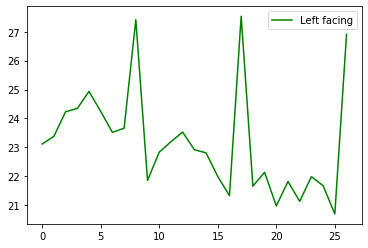

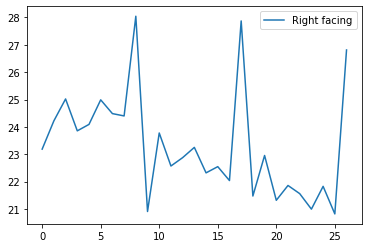

In [169]:
distances_left = []
distances_right = []

for i in range(len(hog_feats_test)):
    distances_left.append(cv2.norm(hog_feats_test[i], hog_mean_left))
    distances_right.append(cv2.norm(hog_feats_test[i], hog_mean_right))

plt.plot(np.arange(len(distances_left)), distances_left, label= "Left facing", color ='g')
plt.legend()
plt.show()
plt.plot(np.arange(len(distances_right)), distances_right, label= "Right facing")
plt.legend()
plt.show()
    



### 4 - Threshold the two distances to detect cars in the test image. Display detected window

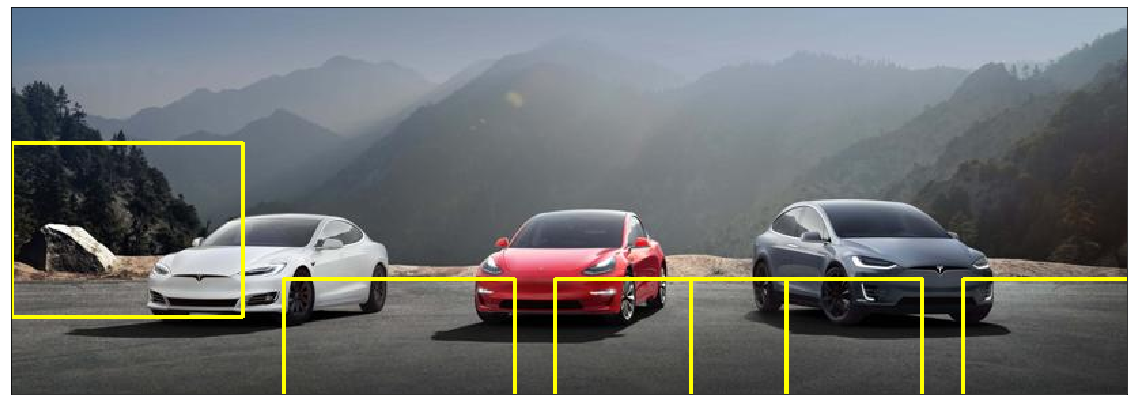

In [170]:
testImage1 = testImage.copy()
detectedCars = []
for i in range(len(distances_left)):
    if distances_right[i] <= 21.3 or distances_left[i] <= 21.2:
        xPos = windows[i][1]
        yPos = windows[i][2]
        cv2.rectangle(testImage1, (xPos, yPos), (xPos + heightW, yPos + widthW), (255, 255, 0), 2)
        detectedCars.append(np.array(testImage[yPos:yPos + widthW , xPos:xPos + heightW]))
    

# draw window on image
plt.figure(figsize=(20,10))
plt.imshow(testImage1), plt.xticks([]), plt.yticks([])
plt.show()

### 5 - Experiment with size of the window, stride and the detection threshold to achieve accuracy

5


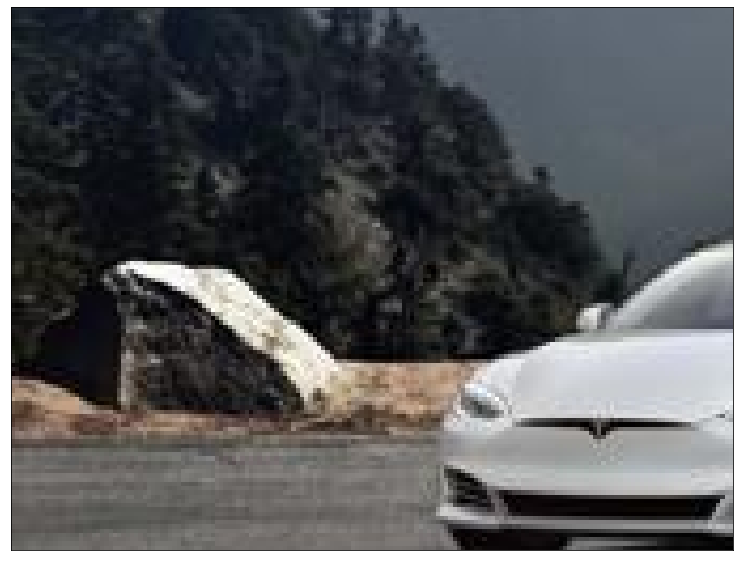

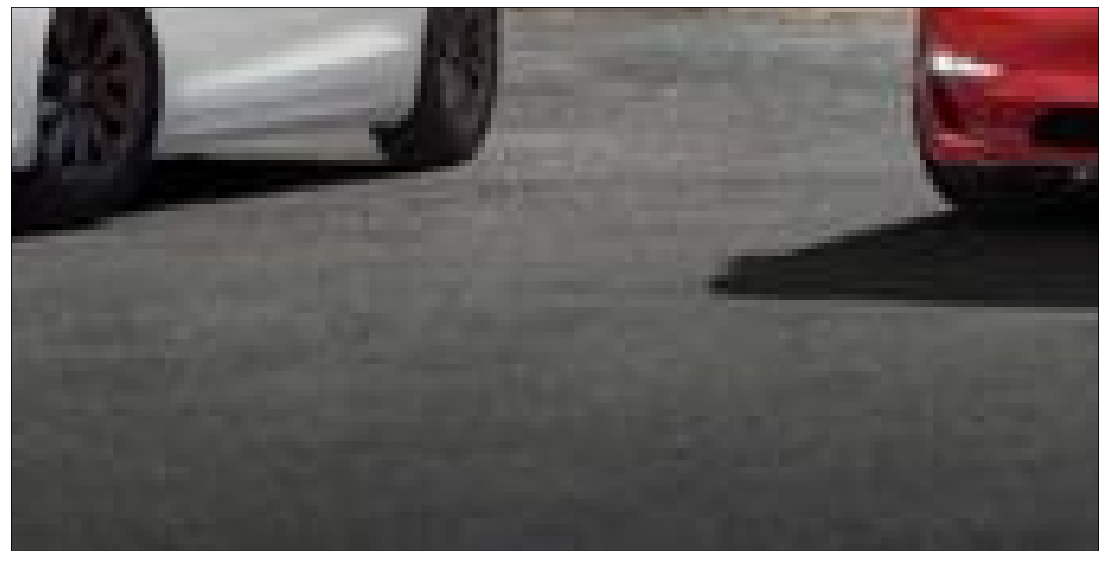

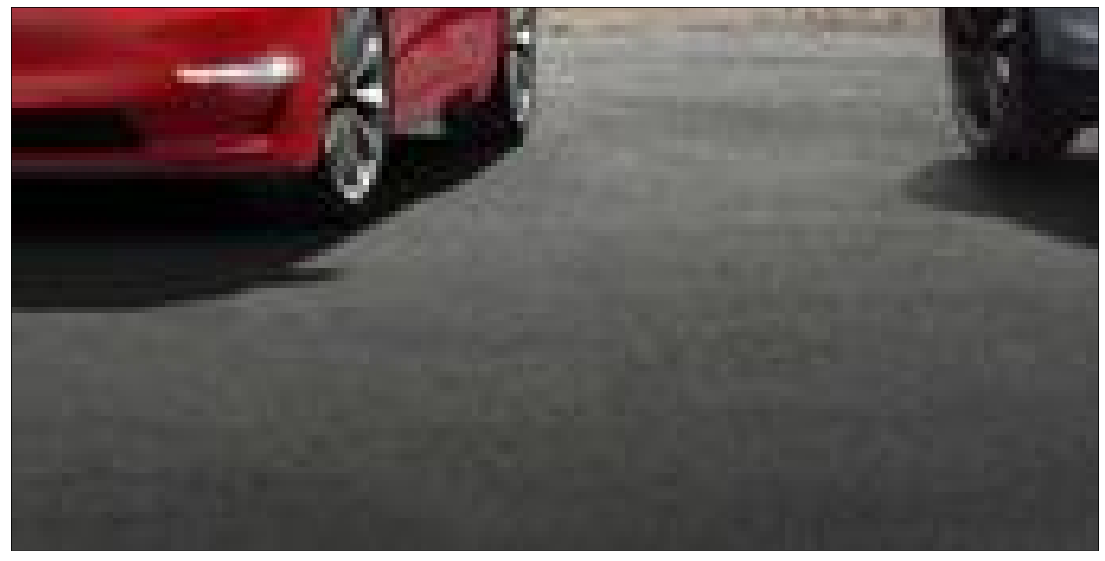

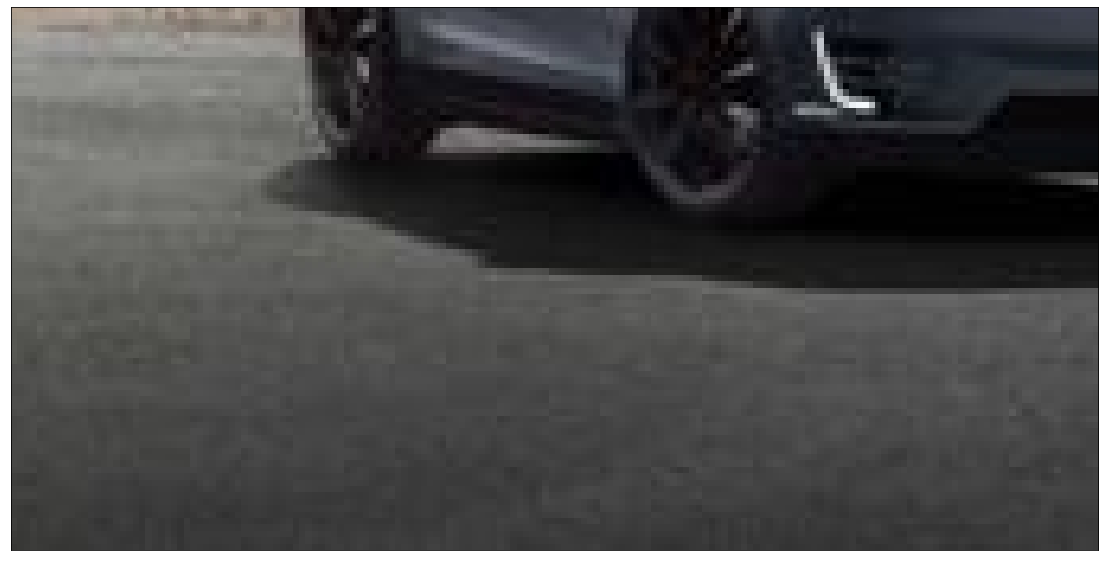

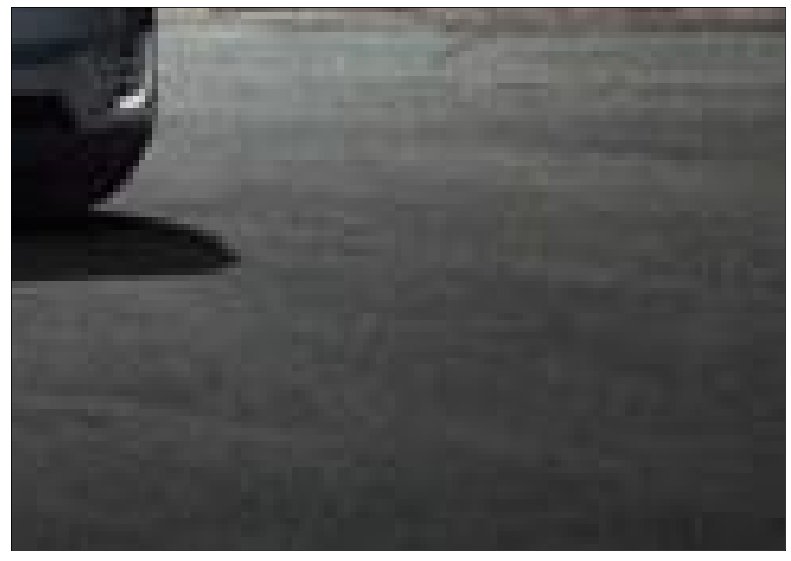

In [171]:
# size of window = 170x128 , stride = 100, threshold left = 21.2, threshold right = 21.3
print(len(detectedCars))
for image in detectedCars:
    plt.figure(figsize=(20,10))
    plt.imshow(image), plt.xticks([]), plt.yticks([])
    # show all windows
    plt.show()